**Ahora veremos 3 maneras Tensorflow, Keras y Sklearn.**

Pues como en todo edificio debemos de empezar a construir por los cimientos. Esto es muy común dentro del campo de la informática. Donde muchas
de las herramientas se contruyen encima de otras herramientas anteriores. Vamos aumentando capa por capa, abstrayendo funcionalisdades complejas en herramientas cada vez más sencillas de utilizar.

Es decir, si trabajamos con Deeplearning, cada que añadimos sumará una capa de simplicidad en las redes neuronales, pero al mismo tiempo nos restará dlexibilidad en el disño de las arquitecturas.

Anteriormente, hemos podido calcular una red neural paso por paso, línea por línea. Si querría experimentar con el diseño de la red, tendríamos que cambiar todo el código. Coger papel y boli y recalcular todo... Debe de haber una forma más sencilla...

Si al menos existiera una forma en la que yo pudiera definir qué operaciones quiero que se ejecuten dentro de mi red y que de manera automática y que el código fuera capaz de calcular todas las derivadas parciales que necesito hacer para el algoritmo de backpropagation.

Pues existe...

Tenemos que adentraros a las líbrerias de diferenciación automática. Aquí nos vamos a encontrar con diferentes herramientas donde TensorFlow y Paytorch destacan.

Como dice su nombre, se van a encargan de calcular automáticamente las derivadas parciales de cualquier arquitectura que se diseñe. Internamente, para conseguir esta diferenciacion automática, estas librerias presentas todas las operaciones que se han de ejecutarse en nuestra arquitectura como un grafo. Donde cada nodo representa una variable de entrada o una operación a realizar. Se trata del **grafo computacional**.

Es la estructura ideal para iniciar el proceso de diferenciación automática.

En nuestro caso, como ejemplo de librería auto diferenciable, nos centraremos en la versión 1 de TensorFlow para ver cómo podemos implementar nuestra red neuronal y así solucionar nuestro problema binario anterior.


TENSORFLOW

Este va a ser nuestro código inicial:

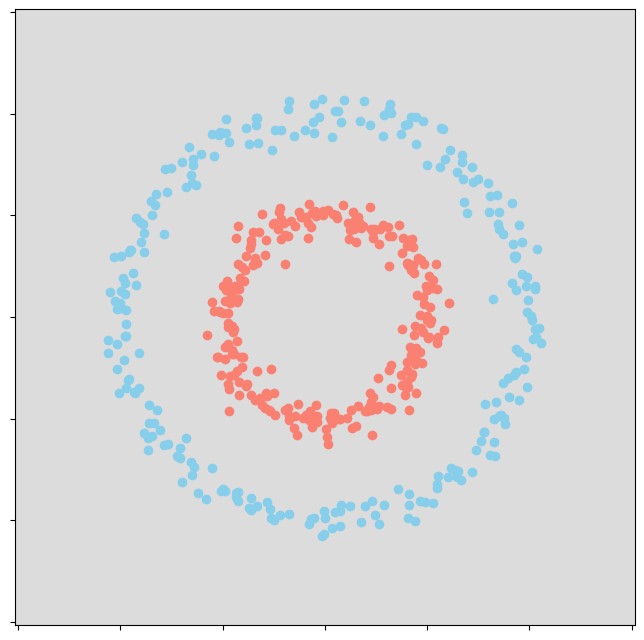

In [ ]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

# Creamos nuestros datos artificiales, donde buscaremos clasificar
# dos anillos concéntricos de datos.
X, Y = make_circles(n_samples=500, factor=0.5, noise=0.05)

# Resolución del mapa de predicción.
res = 100

# Coordendadas del mapa de predicción.
_x0 = np.linspace(-1.5, 1.5, res)
_x1 = np.linspace(-1.5, 1.5, res)

# Input con cada combo de coordenadas del mapa de predicción.
_pX = np.array(np.meshgrid(_x0, _x1)).T.reshape(-1, 2)

# Objeto vacio a 0.5 del mapa de predicción.
_pY = np.zeros((res, res)) + 0.5

# Visualización del mapa de predicción.
plt.figure(figsize=(8, 8))
plt.pcolormesh(_x0, _x1, _pY, cmap="coolwarm", vmin=0, vmax=1)

# Visualización de la nube de datos.
plt.scatter(X[Y == 0,0], X[Y == 0,1], c="skyblue")
plt.scatter(X[Y == 1,0], X[Y == 1,1], c="salmon")

plt.tick_params(labelbottom=False, labelleft=False)

El punto de partida de todo código de TensorFlow para por definir explícitamente qué operaciones forman parte de nuestro grafo computacional. Es decir, cómo los datos van a ir fluyendo y transformándose de principio a fin.

En TensorFlow, utilizamos los PlaceHolders para definir aquellos puntos de entrada, por donde van a entrar datos en nuestra red.

In [ ]:
import tensorflow as tf

from matplotlib import animation
from IPython.core.display import display, HTML

# Definimos los puntos de entrada de la red, para la matriz X e Y.
iX = tf.keras.Input(shape=(X.shape[1],), dtype=tf.float32)
iY = tf.keras.Input(shape=(1,), dtype=tf.float32)

lr = 0.01           # learning rate
nn = [2, 16, 8, 1]  # número de neuronas por capa.

A partir de aquí ya podemos definir nuestras operaciones que definirán nuestra red neuronal.

como sabemos en cada capa se hace una suma ponderada que es equivalente a multiplicación matricial, después la suma del parámetro de baias y luego aplicar la función de activación.

Pues fíjate qué sencillo es hacer esto con tensorFlow.

Lo primero que tenemos que hacer es definir aquellos parámetros que van a ser optimizados dentro de nuestra red. Variable. Donde vmaos a indicar que sus valores van a ser inicializados aleatoriamente y que tendra las siguientes dimensiones.

In [ ]:
# Capa 1
W1 = tf.Variable(tf.random_normal([nn[0], nn[1]]), name='Weights_1')
b1 = tf.Variable(tf.random_normal([nn[1]]), name='bias_1')

l1 = tf.nn.relu(tf.add(tf.matmul(iX, W1), b1))

# Capa 2
W2 = tf.Variable(tf.random_normal([nn[1], nn[2]]), name='Weights_2')
b2 = tf.Variable(tf.random_normal([nn[2]]), name='bias_2')

l2 = tf.nn.relu(tf.add(tf.matmul(l1, W2), b2))

# Capa 3
W3 = tf.Variable(tf.random_normal([nn[2], nn[3]]), name='Weights_3')
b3 = tf.Variable(tf.random_normal([nn[3]]), name='bias_3')

In [ ]:

# Vector de predicciones de Y.
pY = tf.nn.sigmoid(tf.add(tf.matmul(l2, W3), b3))[:, 0]


# Evaluación de las predicciones.
loss = tf.losses.mean_squared_error(pY, iY)

# Definimos al optimizador de la red, para que minimice el error.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)

n_steps = 1000 # Número de ciclos de entrenamiento.

iPY = [] # Aquí guardaremos la evolución de las predicción, para la animación.


Aquí vamos a evaluar los datos.

In [ ]:
with tf.Session() as sess:

  # Inicializamos todos los parámetros de la red, las matrices W y b.
  sess.run(tf.global_variables_initializer())

  # Iteramos n pases de entrenamiento.
  for step in range(n_steps):

    # Evaluamos al optimizador, a la función de coste y al tensor de salida pY.
    # La evaluación del optimizer producirá el entrenamiento de la red.
    _, _loss, _pY = sess.run([optimizer, loss, pY], feed_dict={ iX : X, iY : Y })

    # Cada 25 iteraciones, imprimimos métricas.
    if step % 25 == 0:

      # Cálculo del accuracy.
      acc = np.mean(np.round(_pY) == Y)

      # Impresión de métricas.
      print('Step', step, '/', n_steps, '- Loss = ', _loss, '- Acc =', acc)

      # Obtenemos predicciones para cada punto de nuestro mapa de predicción _pX.
      _pY = sess.run(pY, feed_dict={ iX : _pX }).reshape((res, res))

      # Y lo guardamos para visualizar la animación.
      iPY.append(_pY)

In [ ]:
# ----- CÓDIGO ANIMACIÓN ----- #

ims = []

fig = plt.figure(figsize=(10, 10))

print("--- Generando animación ---")

for fr in range(len(iPY)):

  im = plt.pcolormesh(_x0, _x1, iPY[fr], cmap="coolwarm", animated=True)

  # Visualización de la nube de datos.
  plt.scatter(X[Y == 0,0], X[Y == 0,1], c="skyblue")
  plt.scatter(X[Y == 1,0], X[Y == 1,1], c="salmon")

  # plt.title("Resultado Clasificación")
  plt.tick_params(labelbottom=False, labelleft=False)

  ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

HTML(ani.to_html5_video())

KERAS

Podríamos simplificar de manera más fácil. Interfaz de composición de capas de Tensorflow.
Lo que consigue es una interfaz sencilla a nivel de capa de todas las funcionalidades que nos propociona TensorFlow.

In [ ]:
import tensorflow as tf
import tensorflow.keras as kr

from IPython.core.display import display, HTML


lr = 0.01           # learning rate
nn = [2, 16, 8, 1]  # número de neuronas por capa.


# Creamos el objeto que contendrá a nuestra red neuronal, como
# secuencia de capas.
model = kr.Sequential()

# Añadimos la capa 1
l1 = model.add(kr.layers.Dense(nn[1], activation='relu'))

# Añadimos la capa 2
l2 = model.add(kr.layers.Dense(nn[2], activation='relu'))

# Añadimos la capa 3
l3 = model.add(kr.layers.Dense(nn[3], activation='sigmoid'))

# Compilamos el modelo, definiendo la función de coste y el optimizador.
model.compile(loss='mse', optimizer=kr.optimizers.SGD(lr=0.05), metrics=['acc'])

# Y entrenamos al modelo. Los callbacks
model.fit(X, Y, epochs=100)

Epoch 1/100
16/16 [==============================] - 1s 2ms/step - loss: 0.2430 - acc: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2428 - acc: 0.5000
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2426 - acc: 0.5000
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2424 - acc: 0.5000
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2423 - acc: 0.5000
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2421 - acc: 0.5000
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2419 - acc: 0.5000
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2417 - acc: 0.5000
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2415 - acc: 0.5000
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2413 - acc: 0.5000
Epoch 11/100
16/16 [==============================] - 0s 2m

Para ilustrar esto podemos subir un último nivel, donde vamos pasaremos a tratar las redes neuronales desde un punto de vista de capas, a un punto de vista de modelo.

En este nivel, las cosas se vuelven las cosas se vuelven más sencilas. Donde vemos las redes neuronales como un todo.Como un modelo cuya arquitectura ya nos tan predefinida y podemos ajustar de manera limitada ajustando unos pocos hiperparametros.

En este nivel podemos encontrarnos, con scikit Learn, APIs en plataformas de machile learning en la nube o paquetes avanzados en herramientas de ofimática. Estas te ofrecen una amplia serie de modelos, como KNN, modelos logísticos o lineales o como cosas más avanzadas como redes neuronales.

Es muy simple de simplificar, la dificultad reside en la de encontrar aquellos hyperparametros que mejor se ajusten a tu problema.

In [ ]:
import sklearn as sk
import sklearn.neural_network

from IPython.core.display import display, HTML


lr = 0.01           # learning rate
nn = [2, 16, 8, 1]  # número de neuronas por capa.

# Creamos el objeto del modelo de red neuronal multicapa.
clf = sk.neural_network.MLPRegressor(solver='sgd',
                                     learning_rate_init=lr,
                                     hidden_layer_sizes=tuple(nn[1:]),
                                     verbose=True,
                                     n_iter_no_change=1000,
                                     batch_size = 64)


# Y lo entrenamos con nuestro datos.
clf.fit(X, Y)

Iteration 1, loss = 0.18083211
Iteration 2, loss = 0.14387959
Iteration 3, loss = 0.12691023
Iteration 4, loss = 0.12514873
Iteration 5, loss = 0.12597522
Iteration 6, loss = 0.12570110
Iteration 7, loss = 0.12526553
Iteration 8, loss = 0.12515579
Iteration 9, loss = 0.12508355
Iteration 10, loss = 0.12510208
Iteration 11, loss = 0.12509524
Iteration 12, loss = 0.12505394
Iteration 13, loss = 0.12516633
Iteration 14, loss = 0.12506458
Iteration 15, loss = 0.12504157
Iteration 16, loss = 0.12506070
Iteration 17, loss = 0.12505823
Iteration 18, loss = 0.12516185
Iteration 19, loss = 0.12502652
Iteration 20, loss = 0.12506784
Iteration 21, loss = 0.12505716
Iteration 22, loss = 0.12504455
Iteration 23, loss = 0.12502557
Iteration 24, loss = 0.12503050
Iteration 25, loss = 0.12507861
Iteration 26, loss = 0.12507159
Iteration 27, loss = 0.12506529
Iteration 28, loss = 0.12503922
Iteration 29, loss = 0.12504412
Iteration 30, loss = 0.12503891
Iteration 31, loss = 0.12504924
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(batch_size=64, hidden_layer_sizes=(16, 8, 1),
             learning_rate_init=0.01, n_iter_no_change=1000, solver='sgd',
             verbose=True)